In [1]:
# Imports
import numpy as np
from numpy import genfromtxt
import pylab as pl
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from tensorflow.python.framework import ops
import urllib
import random
import sys
from IPython.display import clear_output
import re
import os, os.path, gc, time, shutil, matplotlib, glob

/Users/SerG1oAC/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:



modelPath = './transfer4uspVGG16NonEQUVerify_Jul_0518'
if not os.path.isdir(modelPath):
    os.makedirs(modelPath)


In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# Image set directory root
imgRoot = '/Users/SerG1oAC/Documents/dbintroUdacity/fullstack/vagrant/ggStreetView/map/localidades/chapinero/imgs/'

# Load published images
pblImgFile = open('mstrPublishedLst', 'r') 
pblImgSet =  pblImgFile.readlines() 
print('Published Image quantity: ' + str(len(pblImgSet)))
print(pblImgSet[0][:-2])
print(pblImgSet[len(pblImgSet) - 1][:-2])
print(pblImgSet[-1][:-2])

Published Image quantity: 5505
'4.62406833671_-74.0571218553_-90.jpg'
'4.6461951_-74.0536636_180.jpg'
'4.6461951_-74.0536636_180.jpg'


### Building training set

In [5]:
# Load image feature vectors extracted with the specified model
imageFeatures = genfromtxt('VGG19Chapinero_Ftrs.csv', delimiter=',')

In [6]:
print("Image featured set shape: ", imageFeatures.shape)
imgFtrStd = np.expand_dims(np.std(imageFeatures, axis=0), axis=0) 
imgFtrMean = np.expand_dims(np.mean(imageFeatures, axis=0) , axis=0) 
imgNrmFeatures = ((imageFeatures - imgFtrMean)/(imgFtrStd+0.00000000001))

Image featured set shape:  (5505, 512)


In [22]:

# Load vote indexer file
# voteSetFile = 'descriptorIndexerNonEQUX_Jun_0418.txt'
voteSetFile = 'descriptorIndexerNonEQUX_Jul_0518.txt'
# voteSetFile = 'descriptorIndexerNonEQUX_May_2718.txt'
# voteSetFile = 'descriptorIndexerNonEQU_May_2718.txt'
# voteSetFile = 'descriptorIndexerHBoostX_May_2718.txt'
# voteSetFile = 'descriptorIndexerHBoostX_Nov_24.txt'
# voteSetFile = 'descriptorIndexer_Nov_24.txt'
# voteSetFile = 'descriptorIndexerNrml_Nov_24.txt'
# voteSetFile = 'escriptorIndexerBoost_Nov_24.txt'
# voteSetFile = 'descriptorIndexerHBoost_Nov_24.txt'
# voteSetFile = 'descriptorIndexerNrml_Nov_05.txt'
# voteSetFile = 'escriptorIndexerBoost_Nov_05.txt' # %75!!! with DROP-OUT
# voteSetFile = 'descriptorIndexerHBoost_Nov_05.txt'
print("Training/Validation Set description from " + voteSetFile)

votesIndex = genfromtxt(voteSetFile, delimiter=',')
print("Vote set shape                   ", votesIndex.shape)


# training percentage
perTrain = 70
print('Training percentage              ' , perTrain,'%')
# miniBatch Size
minibatch_size = 64
print('Training mini batch size         ' , minibatch_size)
# Total amount of training votes
ImgVtTrainSize = np.int(np.floor((votesIndex.shape[0]*perTrain)/100))
print("Total amount of training votes   " , ImgVtTrainSize)
# Total amount of test votes
ImgVtTestSize = votesIndex.shape[0] - ImgVtTrainSize
print("Total amount of test votes       " , ImgVtTestSize)
num_minibatches = int(ImgVtTrainSize / minibatch_size)
LastBatchSize = ImgVtTrainSize - num_minibatches*minibatch_size
if LastBatchSize > 0:
    num_minibatches = num_minibatches + 1
print("Number of training mini batches  " , num_minibatches)
print("Last batch size                  ", LastBatchSize)
#--Test figures
iniTestIdx = ImgVtTrainSize
num_Testminibatches = int(ImgVtTestSize / minibatch_size)
LastTestBatchSize = ImgVtTestSize - num_Testminibatches*minibatch_size
if LastTestBatchSize > 0:
    num_Testminibatches = num_Testminibatches + 1
print("Number of test mini batches      " , num_Testminibatches)
print("Last test batch size             ", LastTestBatchSize)

testZ = 0
testO = 0
testT = 0 
for i in range(votesIndex.shape[0]-ImgVtTestSize, votesIndex.shape[0]):
    if votesIndex[i][2] == 0:
        testZ += 1
    elif votesIndex[i][2] == 1:
        testO += 1
    else:
        testT += 1
        
print("Test Zeros %i, Ones %i, Twos %i" % (testZ, testO, testT))

trainZ = 0
trainO = 0
trainT = 0 
for i in range(0, votesIndex.shape[0]-ImgVtTestSize):
    if votesIndex[i][2] == 0:
        trainZ += 1
    elif votesIndex[i][2] == 1:
        trainO += 1
    else:
        trainT += 1
        
print("Train Zeros %i, Ones %i, Twos %i" % (trainZ, trainO, trainT))

Training/Validation Set description from descriptorIndexerNonEQUX_Jul_0518.txt
Vote set shape                    (25538, 3)
Training percentage               70 %
Training mini batch size          64
Total amount of training votes    17876
Total amount of test votes        7662
Number of training mini batches   280
Last batch size                   20
Number of test mini batches       120
Last test batch size              46
Test Zeros 0, Ones 3831, Twos 3831
Train Zeros 0, Ones 8938, Twos 8938


In [23]:
def getMiniBatch(minbIdx, prm = None):
    # minbIdx: miniBatch index
    # training set permutation array
    iniIdx = minbIdx * minibatch_size
    endIdx = iniIdx + minibatch_size - 1
    if endIdx > (ImgVtTrainSize - 1):
        endIdx = ImgVtTrainSize - 1
    vsize = (endIdx - iniIdx) + 1  
    # build room
    x_train_orig = np.zeros((vsize, imageFeatures.shape[1]*2)) 
    y_train_orig = np.zeros((vsize,2))
    idxIte = 0
    for i in range(iniIdx,(endIdx+1)):
        imgAIdx = 0
        imgBIdx = 0
        voteCode = 0
        if prm == None:
            imgAIdx = votesIndex[i][0] - 1
            imgBIdx = votesIndex[i][1] - 1
            voteCode = votesIndex[i][2]
        else:
            imgAIdx = votesIndex[prm[i]][0] - 1
            imgBIdx = votesIndex[prm[i]][1] - 1
            voteCode = votesIndex[prm[i]][2]
        
        y_train_orig[idxIte] = np.zeros((1,2))
        y_train_orig[idxIte][np.int(voteCode-1)] = 1 
        x_train_orig[idxIte] = np.expand_dims(np.concatenate((imgNrmFeatures[np.int(imgAIdx)], imgNrmFeatures[np.int(imgBIdx)]), axis=0), axis=0)[0]
            
        idxIte =  idxIte + 1

    return  x_train_orig, y_train_orig     
        
    

def getTestMiniBatch(minTbIdx):
    # minbIdx: miniBatch index
    # training set permutation array
    minbIdx = int(minTbIdx%num_Testminibatches)
    
    iniIdx = minbIdx * minibatch_size
    endIdx = iniIdx + minibatch_size - 1
    if endIdx > (ImgVtTestSize - 1):
        endIdx = ImgVtTestSize - 1
    vsize = (endIdx - iniIdx) + 1  
    # build room
    x_train_orig = np.zeros((vsize, imageFeatures.shape[1]*2)) 
    y_train_orig = np.zeros((vsize,2))
    idxIte = 0
    for i in range(iniIdx,(endIdx+1)):
        imgAIdx = votesIndex[i][0] - 1
        imgBIdx = votesIndex[i][1] - 1
        voteCode = votesIndex[i][2]
        
        y_train_orig[idxIte] = np.zeros((1,2))
        y_train_orig[idxIte][np.int(voteCode-1)] = 1 
        x_train_orig[idxIte] = np.expand_dims(np.concatenate((imgNrmFeatures[np.int(imgAIdx)], imgNrmFeatures[np.int(imgBIdx)]), axis=0), axis=0)[0]
            
        idxIte =  idxIte + 1
    
    return  x_train_orig, y_train_orig

def getTestSet():
    # build room
    x_train_orig = np.zeros((ImgVtTestSize, imageFeatures.shape[1]*2)) 
    y_train_orig = np.zeros((ImgVtTestSize,2))
    idxIte = 0
    for i in range(votesIndex.shape[0]-ImgVtTestSize, votesIndex.shape[0]):
        imgAIdx = votesIndex[i][0] - 1
        imgBIdx = votesIndex[i][1] - 1
        voteCode = votesIndex[i][2]
        
        y_train_orig[idxIte] = np.zeros((1,2))
        y_train_orig[idxIte][np.int(voteCode-1)] = 1 
        x_train_orig[idxIte] = np.expand_dims(np.concatenate((imgNrmFeatures[np.int(imgAIdx)], imgNrmFeatures[np.int(imgBIdx)]), axis=0), axis=0)[0]
            
        idxIte =  idxIte + 1
    
    return  x_train_orig, y_train_orig

In [24]:
gX_test, gY_test = getTestSet()
print("gX_test : " , gX_test.shape)
print("gY_test : " , gY_test.shape)

gX_test :  (7662, 1024)
gY_test :  (7662, 2)


In [25]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, shape=(None,n_x), name = 'X') 
    Y = tf.placeholder(tf.float32, shape=(None, n_y), name = 'Y')
    DRP_En = tf.placeholder(tf.bool, shape=(), name = 'DRP_En')
    
    return X,Y,DRP_En

In [26]:
def forward_propagationBackup(X, DRP_En):
    
    prtVlmSize = True
    # Nov 05
    # 0.3, 0.25, 0.2 => 78% over test
    # 0.4, 0.3, 0.2 => 78.4% over test
    # Nov 25
    # 0.44, 0.33, 0.22 => 72% over test
    # 0.5, 0.4, 0.3 => 73% over test
    DRPOUT_X = tf.layers.dropout(inputs=X, rate=0.5, training=DRP_En)
    Z4 = tf.contrib.layers.fully_connected(DRPOUT_X, 1024)
    DRPOUT_Z4 = tf.layers.dropout(inputs=Z4, rate=0.45, training=DRP_En)
    Z5 = tf.contrib.layers.fully_connected(DRPOUT_Z4, 512)
    DRPOUT_Z5 = tf.layers.dropout(inputs=Z5, rate=0.4, training=DRP_En)
    Z6p = tf.contrib.layers.fully_connected(DRPOUT_Z5, 256)
    DRPOUT_Z6p = tf.layers.dropout(inputs=Z6p, rate=0.35, training=DRP_En)
    Z6pp = tf.contrib.layers.fully_connected(DRPOUT_Z6p, 128)
    DRPOUT_Z6pp = tf.layers.dropout(inputs=Z6pp, rate=0.3, training=DRP_En)
    Z6 = tf.contrib.layers.fully_connected(DRPOUT_Z6pp, 3, activation_fn=None)
    
    return Z6

In [27]:
def forward_propagationWinner(X, DRP_En):
    """
    This setup works well along with
    VGG19_Ftrs.csv features
    59.7%
    learning rate 0.00001
    80 20
    minibatch size 64
    """
    
    DRPOUT_X = tf.layers.dropout(inputs=X, rate=0.5, training=DRP_En)
    Z4 = tf.contrib.layers.fully_connected(DRPOUT_X, 1024)
    DRPOUT_Z4 = tf.layers.dropout(inputs=Z4, rate=0.45, training=DRP_En)
    Z5 = tf.contrib.layers.fully_connected(DRPOUT_Z4, 512)
    DRPOUT_Z5 = tf.layers.dropout(inputs=Z5, rate=0.3, training=DRP_En)
    Z6 = tf.contrib.layers.fully_connected(DRPOUT_Z5, 3, activation_fn=None)
    
    return Z6

In [28]:
def forward_propagation(X, DRP_En):
    
    
    DRPOUT_X = tf.layers.dropout(inputs=X, rate=0.5, training=DRP_En)
    Z4 = tf.contrib.layers.fully_connected(DRPOUT_X, 1024)
    DRPOUT_Z4 = tf.layers.dropout(inputs=Z4, rate=0.45, training=DRP_En)
    Z5 = tf.contrib.layers.fully_connected(DRPOUT_Z4, 512)
    DRPOUT_Z5 = tf.layers.dropout(inputs=Z5, rate=0.3, training=DRP_En)
    Z6 = tf.contrib.layers.fully_connected(DRPOUT_Z5, 2, activation_fn=None)
    
    return Z6

In [29]:
def compute_cost(Z6, Y):
    # cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Z6, labels = Y))
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z6, labels = Y))
    
    return cost

In [30]:
def model(learning_rate = 0.00001, num_epochs = 250, print_cost = False, minibatch_size = minibatch_size):
    
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(12)                             # to keep results consistent (tensorflow seed)
    seed = 22                                          # to keep results consistent (numpy seed)
                                        
    costs = []                                        # To keep track of the cost
    Testcosts = []
    EpochIteration = []
    ZACCplot = []
    OACCplot = []
    TACCplot = []
    ACCplot = []
    
    X_val = np.zeros((1, imageFeatures.shape[1]*2)) 
    Y_val = np.zeros((1,2))
    lastBestTestCost = -1.
    
    # Create Placeholders of the correct shape
    X, Y, DRP_En = create_placeholders(imageFeatures.shape[1]*2, 2)
     
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z6 = forward_propagation(X, DRP_En)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z6, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    # optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
   
   
    # SAVER ops
    
    PREDICT_op = tf.argmax(Z6, 1, name = 'PREDICT_op')
    SOFTMAX_op = tf.nn.softmax(Z6, name = 'SOFTMAX_op')
    CORRECT_PREDICTION_op = tf.equal(PREDICT_op, tf.argmax(Y, 1), name = 'CORRECT_PREDICTION_op')
    ACCURACY = tf.reduce_mean(tf.cast(CORRECT_PREDICTION_op, "float"), name = 'ACCURACY')
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            EpochIteration.append(epoch)
            minibatch_cost = 0.
            minibatch_testCost = 0.
            seed = seed + 1
            np.random.seed(seed)
            permutation4trn = list(np.random.permutation(ImgVtTrainSize))
            for it in range(0, num_minibatches):
                X_train, Y_train = getMiniBatch(it,permutation4trn)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train, DRP_En: True})
                minibatch_cost += temp_cost / num_minibatches
                
            temp_testcost = cost.eval({X: gX_test, Y: gY_test, DRP_En: False})
            minibatch_testCost += temp_testcost/num_Testminibatches
            
            
            # build cost list
            costs.append(minibatch_cost)
            Testcosts.append(temp_testcost)
            
            print("Epoch %i  train cost %.3f test cost %.3f" % (epoch,minibatch_cost,temp_testcost))
            
            
            test_accuracy = ACCURACY.eval({X: gX_test, Y: gY_test, DRP_En: False})
            if test_accuracy > lastBestTestCost:
                lastBestTestCost = test_accuracy
                # remove previuous best model
                files = glob.glob(modelPath + '/*')
                for f in files:
                    os.remove(f)
                # Save the variables to disk.
                print("New Test Accuaracy: %.3f !!!" % (test_accuracy)) 
                saver.save(sess, modelPath + '/model' + str(int((test_accuracy)*100)))
               
            
                
        # plot the cost
        plt.plot(np.squeeze(EpochIteration), np.squeeze(costs), 'r-', np.squeeze(EpochIteration), np.squeeze(Testcosts), 'b-')
        plt.ylabel('costs(r)-testcosts(b)')
        plt.xlabel('epoch iteration')
        plt.title("Learning rate =" + str(learning_rate))
        plt.savefig('nn4usp', format='pdf')
        plt.show()    
        
   
                
        return costs,Testcosts

Epoch 0  train cost 1.013 test cost 0.613
New Test Accuaracy: 0.668 !!!
Epoch 1  train cost 0.857 test cost 0.543
New Test Accuaracy: 0.725 !!!
Epoch 2  train cost 0.789 test cost 0.514
New Test Accuaracy: 0.745 !!!
Epoch 3  train cost 0.730 test cost 0.490
New Test Accuaracy: 0.760 !!!
Epoch 4  train cost 0.686 test cost 0.478
New Test Accuaracy: 0.767 !!!
Epoch 5  train cost 0.670 test cost 0.473
New Test Accuaracy: 0.769 !!!
Epoch 6  train cost 0.647 test cost 0.469
New Test Accuaracy: 0.773 !!!
Epoch 7  train cost 0.633 test cost 0.461
New Test Accuaracy: 0.779 !!!
Epoch 8  train cost 0.623 test cost 0.457
New Test Accuaracy: 0.781 !!!
Epoch 9  train cost 0.614 test cost 0.455
New Test Accuaracy: 0.782 !!!
Epoch 10  train cost 0.598 test cost 0.453
New Test Accuaracy: 0.783 !!!
Epoch 11  train cost 0.585 test cost 0.448
New Test Accuaracy: 0.786 !!!
Epoch 12  train cost 0.582 test cost 0.447
New Test Accuaracy: 0.787 !!!
Epoch 13  train cost 0.573 test cost 0.446
New Test Accuaracy

Epoch 149  train cost 0.399 test cost 0.408
Epoch 150  train cost 0.398 test cost 0.407
Epoch 151  train cost 0.399 test cost 0.407
Epoch 152  train cost 0.396 test cost 0.407
Epoch 153  train cost 0.396 test cost 0.406
Epoch 154  train cost 0.393 test cost 0.406
Epoch 155  train cost 0.390 test cost 0.405
Epoch 156  train cost 0.391 test cost 0.405
Epoch 157  train cost 0.398 test cost 0.405
Epoch 158  train cost 0.391 test cost 0.404
Epoch 159  train cost 0.390 test cost 0.403
Epoch 160  train cost 0.390 test cost 0.404
Epoch 161  train cost 0.393 test cost 0.403
Epoch 162  train cost 0.392 test cost 0.403
Epoch 163  train cost 0.391 test cost 0.404
Epoch 164  train cost 0.394 test cost 0.404
Epoch 165  train cost 0.389 test cost 0.403
Epoch 166  train cost 0.391 test cost 0.402
Epoch 167  train cost 0.388 test cost 0.402
Epoch 168  train cost 0.389 test cost 0.402
Epoch 169  train cost 0.384 test cost 0.402
Epoch 170  train cost 0.384 test cost 0.401
Epoch 171  train cost 0.389 test

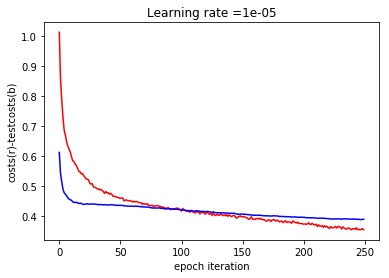

In [31]:
costs,Testcosts = model()

INFO:tensorflow:Restoring parameters from ./transfer4uspVGG16NonEQUVerify_Jul_0518/model82
Confusion matrix, without normalization
[[2140  414]
 [ 360 2195]]


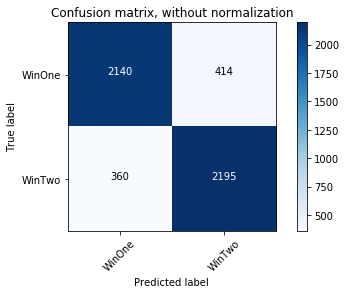

ONE_ACC :  0.838
TWO_ACC :  0.859
GACC :     0.849


In [29]:
saver4Pre = tf.train.import_meta_graph('./transfer4uspVGG16NonEQUVerify_Jul_0518/model82.meta')
with tf.Session() as sess:
    # Step-2: Now let's load the weights saved using the restore method.
    saver4Pre.restore(sess, tf.train.latest_checkpoint('./transfer4uspVGG16NonEQUVerify_Jul_0518'))
    # Accessing the default graph which we have restored
    graph = tf.get_default_graph()
    # Now, let's get hold of the op that we can be processed to get the output.
    # In the original network y_pred is the tensor that is the prediction of the network
    PREDICT_op = graph.get_tensor_by_name("PREDICT_op:0")
    SOFTMAX_op = graph.get_tensor_by_name('SOFTMAX_op:0')
    X = graph.get_tensor_by_name("X:0") 
    
    Y = graph.get_tensor_by_name("Y:0")
    DRP_En = graph.get_tensor_by_name("DRP_En:0")
    # for i in range(0, votesIndex.shape[0]):
    X_val = np.zeros((1, imageFeatures.shape[1]*2)) 
    Y_val = np.zeros((1,2))
    # for i in range(0, votesIndex.shape[0]):
    prediction = []
    actulLabel = []
   
    # for i in range(22338, 24092):
    # for i in range(0, votesIndex.shape[0]-ImgVtTestSize):
    # for i in range(votesIndex.shape[0]-ImgVtTestSize, votesIndex.shape[0]):
    # for i in range(votesIndex.shape[0]-ImgVtTestSize, (votesIndex.shape[0]-ImgVtTestSize + 2553)):
    for i in range((votesIndex.shape[0]-ImgVtTestSize + 2553), votesIndex.shape[0]):
        # minus 1 because originall indexing list was done in MATLAB.
        # MATLAB index stars at 1
        imgAIdx = votesIndex[i][0] - 1
        imgBIdx = votesIndex[i][1] - 1
        voteCode = votesIndex[i][2]
        
        Y_val = np.zeros((1,2))
        Y_val[0][np.int(voteCode-1)] = 1
        X_val[0] = np.expand_dims(np.concatenate((imgNrmFeatures[np.int(imgAIdx)], imgNrmFeatures[np.int(imgBIdx)]), axis=0), axis=0)[0]
        
        result = sess.run(PREDICT_op, feed_dict={X: X_val, Y: Y_val, DRP_En: False})
        prediction.append(np.int(result[0]))
        actulLabel.append(np.int(voteCode-1))
        
    
    
    
    
    # pout = np.concatenate((np.transpose(actulLabelArr), np.transpose(predictionArr)), axis=1)
    # print(pout)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(np.asarray(actulLabel), np.asarray(prediction))
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    class_names = ['WinOne', 'WinTwo']
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
    plt.show()
    ONE_ACC = cnf_matrix[0][0]/(cnf_matrix[0][0] + cnf_matrix[0][1])
    TWO_ACC = cnf_matrix[1][1]/(cnf_matrix[1][0] + cnf_matrix[1][1])
    GACC = (cnf_matrix[0][0] + cnf_matrix[1][1] )/(np.sum(cnf_matrix))
                                   
    print('ONE_ACC :  ' + ('%.3f' % ONE_ACC))
    print('TWO_ACC :  ' + ('%.3f' % TWO_ACC))
    print('GACC :     ' + ('%.3f' % GACC))